In [1]:
import os
import random
import shutil

source = 'images100'
dest = 'testSet'
files = os.listdir(source)
no_of_files = len(files) // 100
daFare=False #gia fatto quindi non e' necessario rifarlo( misura precauzionale)
if daFare:
    for file_name in random.sample(files, no_of_files):
        shutil.move(os.path.join(source, file_name), dest)

In [2]:
from scripts import commonUtils as alex
if daFare:
    alex.resizeImages("randomImages","testSet",(100,100))


2025-01-27 16:29:17.307321: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 16:29:17.332621: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-27 16:29:17.332642: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-27 16:29:17.332647: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 16:29:17.337093: I tensorflow/core/platform/cpu_feature_g

In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image
def ssim_loss(y_true,y_pred ):
  result=0
  for i in range(0,3):
      result+=tf.reduce_mean(tf.image.ssim(y_true[:][:][i], y_pred[:][:][i], 1.0))
  return 1.0-result/3.0

def costum_loss(y_true,y_pred ):
  loss=tf.losses.mse(y_true,y_pred)
  ssim_cal=ssim_loss(y_true,y_pred)
  return loss+loss*ssim_cal
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda

autoencoder=tf.keras.models.load_model("BUONOmaSemplice",{"ssim_loss":ssim_loss,"costum_loss":costum_loss})

original=Image.open("testSet/divano1.jpeg")

process_image = lambda x:tf.expand_dims( np.array(x)/255,axis=0)
original=process_image(original)
res=autoencoder.encoder(original)
result=autoencoder.decoder(res).numpy()
process_array = lambda x: (np.clip(x,0.0,1.0) * 255).astype(np.uint8)
Image.fromarray(process_array(result[0])).show()
Image.fromarray(process_array(res[0])).show()
def getStats(encoded,normal):
    shape=(100,100)
    media=0
    result=0
    for i in range(0,len(encoded)):
            dec= encoded[i]
            nor= normal[i]
            for j in range(0,3):
                 media+=0.333*tf.image.ssim(tf.constant(np.reshape(dec[:,:,j],(100,100,1)), dtype='float32'), tf.constant(np.reshape(nor[:,:,j],(100,100,1)), dtype='float32'), max_val=1.0).numpy()
    ssimMedia=round(media/len(encoded),3)
    return [ssimMedia]

getStats(original,result)

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda


2025-01-27 16:29:18.558608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-27 16:29:18.590847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-27 16:29:18.590987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[0.972]

In [4]:

testPool=alex.getSamples("testSet",imgSize=(100,100),batchSize=99999,seed=1,split=0.0)
path,dir=testPool.returnPaths()
for i in range(0,len(path)):
    path[i]=dir+"/"+path[i]
qualities = [10, 50,70, 90]  
subsampling_modes = ["4:4:4"]  # solo 4:4:4 per ora che non dovrebber dare perdita di qualita
output_csv = "compression_results.csv"  # Path to the output CSV file
alex.measure_jpeg_compression_to_csv(path[:],(100,100,3),qualities, subsampling_modes, output_csv)

Found 86 files belonging to 1 classes.
Results saved to compression_results.csv


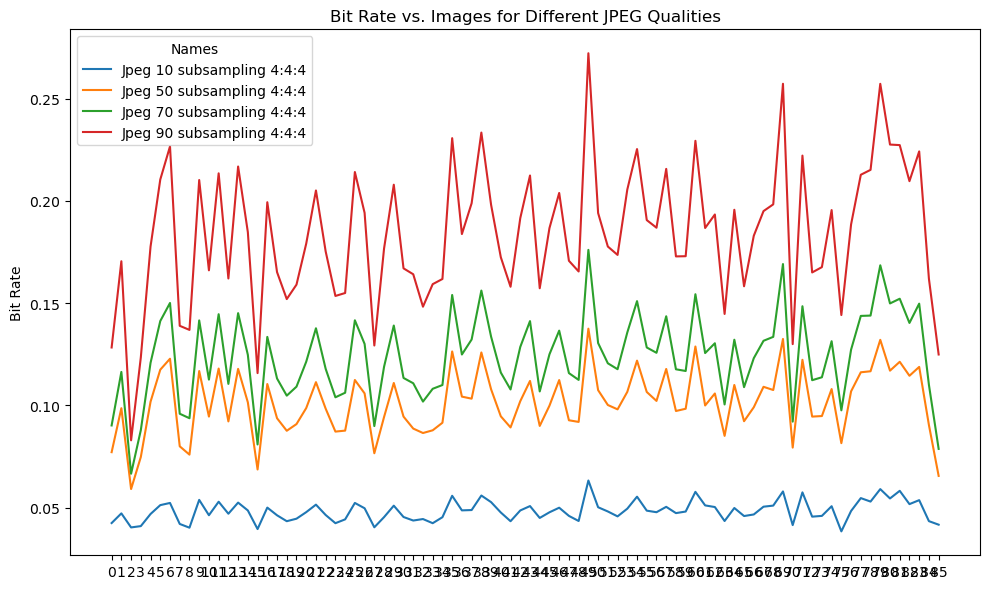

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
output_csv = "compression_results.csv"  # Path to the output CSV file

data = pd.read_csv(output_csv)
data.head()
pivot_table = data.pivot_table(index="image_name", columns="name", values="bit_rate")

# Plot the data
plt.figure(figsize=(10, 6))

# Iterate over each quality level and plot a line
for quality in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[quality], label=f"Jpeg {quality}")

# Add labels and legend
plt.xlabel("")
plt.ylabel("Bit Rate")
plt.title("Bit Rate vs. Images for Different JPEG Qualities")
plt.legend(title="Names")
plt.grid(False)

# Replace x-axis labels with indices
plt.xticks(ticks=range(len(pivot_table.index)), labels=range(len(pivot_table.index)))

# Show the plot
plt.tight_layout()
plt.show()

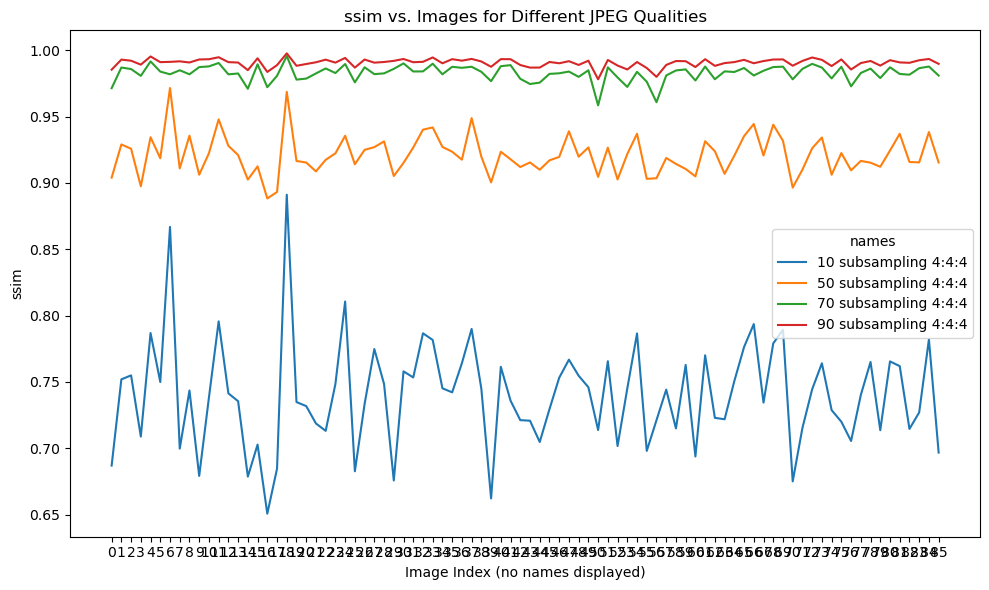

In [6]:

# Group data by chunks of images (e.g., groups of 5 images)
group_size = 1  # Number of images per group
data["group_index"] = data.groupby("name").cumcount() // group_size

# Calculate the average SSIM for each group
grouped_data = data.groupby(["group_index", "name"])["ssim"].mean().reset_index()

# Create a pivot table with the grouped data
pivot_table = grouped_data.pivot(index="group_index", columns="name", values="ssim")

#pivot_table = data.pivot_table(index="image_name", columns="quality", values="ssim")

# Plot the data
plt.figure(figsize=(10, 6))

# Iterate over each quality level and plot a line
for quality in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[quality], label=f"{quality}")

# Add labels and legend
plt.xlabel("Image Index (no names displayed)")
plt.ylabel("ssim")
plt.title("ssim vs. Images for Different JPEG Qualities")
plt.legend(title="names")
plt.grid(False)

# Replace x-axis labels with indices
plt.xticks(ticks=range(len(pivot_table.index)), labels=range(len(pivot_table.index)))

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
data["new_met"]=np.where(data["ssim"]>0.85, (1-data["bit_rate"])*(data["ssim"]), (1-data["bit_rate"])*(pow(data["ssim"],2)))

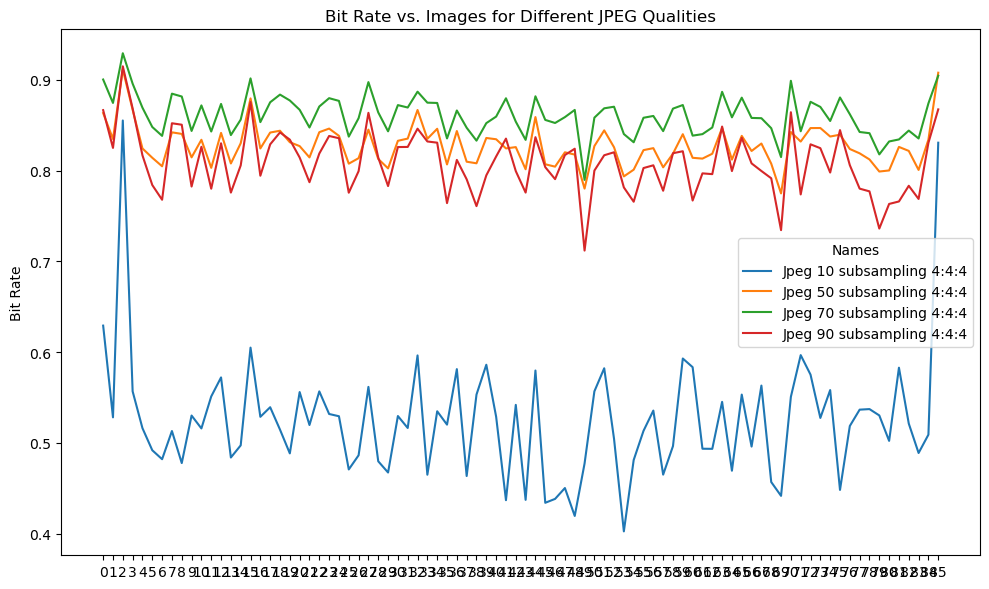

In [8]:
# Iterate over each quality level and plot a line
pivot_table = data.pivot_table(index="image_name", columns="name", values="new_met")
plt.figure(figsize=(10, 6))

for quality in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[quality], label=f"Jpeg {quality}")

# Add labels and legend
plt.xlabel("")
plt.ylabel("Bit Rate")
plt.title("Bit Rate vs. Images for Different JPEG Qualities")
plt.legend(title="Names")
plt.grid(False)

# Replace x-axis labels with indices
plt.xticks(ticks=range(len(pivot_table.index)), labels=range(len(pivot_table.index)))

# Show the plot
plt.tight_layout()
plt.show()